In [1]:
from fastai.text import *
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

!pip install ipython-autotime
%load_ext autotime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=4bae993c12d3365d289e2960b8e4fa43778ed1e2bc5e8f2b33276c5cac0fb845
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
# Import Data - Upload train.csv and test.csv files to Colab runtime folder
path = Path('/content')
train_df = pd.read_csv(f'{path}/train.csv')
test_df = pd.read_csv(f'{path}/test.csv')
submission_df = pd.read_csv(f'{path}/test.csv')
train_df.dropna(inplace=True)
print(train_df.shape, test_df.shape)

(27480, 4) (3534, 3)
time: 112 ms


In [3]:
# Combine train and test text for language model
text_df = pd.concat([train_df,test_df]).drop(columns=['textID', 'selected_text'])
text_df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,All alone in this old house again. Thanks for...,positive
3531,I know what you mean. My little dog is sinkin...,negative
3532,_sutra what is your next youtube video gonna b...,positive


time: 33.1 ms


# Data Exploration

What is the count of tweets in each sentiment class? Looking for possible class imbalances.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB
time: 10.2 ms


In [5]:
train_df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

time: 10 ms


In [6]:
# Group sentiment classes together
temp = train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


time: 44.7 ms


In [7]:
# Group together sentiments
temp.style.background_gradient(cmap='Purples')

# Check ration of observations of each sentiment class -- looking for class imbalance
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"},
    ))
fig.show()

time: 1 s


### Question: What is the breakdown of words in "selected text" for each sentiment? 
We will use the jaccard similarity coefficient. This coefficient measure similarity for two *sets*. This number is between 0 and 1 with 0 being perfectly unique and 1 meaning the sets are identical.

In [8]:
def jaccard(str1, str2): 
  """
  Inputs = 'text' column and 'selected_text' column 
  Output = % similarity between two sets
  """
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

time: 3.12 ms


#### Conclusion: Looking at the result of the code below we see that the neutral sentiment has a jaccard similarity score of 97% which means the text and selected_text columns for neutral sentiment are basically identical. We will use this information and will not be doing any text extraction on the neutral sentiment. We will simply copy the values from text into our selected text output.

In [9]:
# Apply jaccard function to data frame 
train_df['jaccard_similarity'] = train_df.apply(lambda x: jaccard(x.text, x.selected_text), axis=1)

# Group by sentiment to see what the average jaccard similarity coefficient is
train_df.groupby('sentiment')['jaccard_similarity'].mean()

sentiment
negative    0.338613
neutral     0.976445
positive    0.314372
Name: jaccard_similarity, dtype: float64

time: 907 ms


#### Question: What is the jaccard score of tweets less than 3 words?

Is it possible to extract words out of very short tweets or should we just copy these values over as well?

Median jaccard similarity for tweets less than 3 words is 1.0


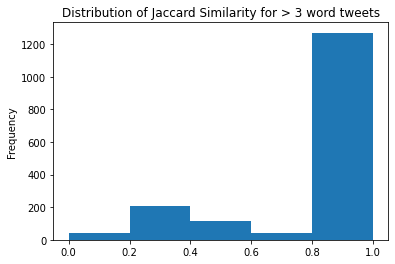

time: 255 ms


In [10]:
# Get number of words in selected text and add a new column to the df
train_df['num_words_selectedtext'] = train_df['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text

# Get number of words in text and add a new column to the df
train_df['Num_word_text'] = train_df['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text

# Plot distribution of jaccard scores for tweets less than 3 words
short_tweet_jaccard_score = train_df.loc[train_df['Num_word_text'] <=3]['jaccard_similarity']

# Plot distribution of jaccard score of tweets less than 3 words
short_tweet_jaccard_score.plot(kind = 'hist',title='Distribution of Jaccard Similarity for > 3 word tweets', bins = 5)

# Print out the median jaccard score
# median score = 1
print(f"Median jaccard similarity for tweets less than 3 words is {short_tweet_jaccard_score.median()}")

#### Conclusion: The median jaccard similarity for these short tweets is a perfect 1. This means if we were looking to speed things up we could use any tweet that is less than 3 words and use that entire tweet for our selected_text output

## Word Clouds


In [11]:
#install the appropriate library directly from their github and name the module for easy importing into google colab
!pip install git+https://github.com/amueller/word_cloud.git #egg=wordcloud

  Cloning https://github.com/amueller/word_cloud.git to /tmp/pip-req-build-6rhh894r
  Running command git clone -q https://github.com/amueller/word_cloud.git /tmp/pip-req-build-6rhh894r
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post92+g51f9983-cp36-cp36m-linux_x86_64.whl size=338628 sha256=8b01f79ac12470337f7b5c90cfc5a9d049aea463b592b1c090fa9dddc12b19a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qurm9ndi/wheels/f6/e8/4a/d14000dae86311eb2b2f1adf9b179fc247858133c757ef42b3
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
time: 14.3 s


In [12]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS


time: 143 ms


#### Here we separate each sentiment into it's own dataframe to create word clouds for each sentiment

In [13]:
pos_word_df = text_df[text_df['sentiment'] == 'positive']
# pos_word_df.head()

time: 6.37 ms


In [14]:
neg_word_df = text_df[text_df['sentiment'] == 'negative']
# neg_word_df.head()

time: 5.09 ms


In [15]:
neutral_word_df = text_df[text_df['sentiment'] == 'neutral']
# neutral_word_df.head()

time: 5.47 ms


In [16]:
# We create a string containing all words in the the tweets for each sentiment
all_text = " ".join(tweet for tweet in text_df.text)
pos_text = " ".join(tweet for tweet in pos_word_df.text)
neg_text = " ".join(tweet for tweet in neg_word_df.text)
neutral_text = " ".join(tweet for tweet in neutral_word_df.text)

time: 13.7 ms


In [17]:
# Here we use wordcloud's default list of stopwords
stopwords = set(STOPWORDS)

time: 588 µs


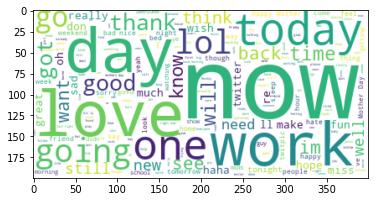

time: 1.83 s


In [18]:
# Verifying our created string works in the wordcloud
worldcloud = WordCloud(stopwords=stopwords, background_color='white').generate(all_text)
plt.imshow(worldcloud, interpolation='bilinear')

#### Here we create the mask, over which our word clouds will be created

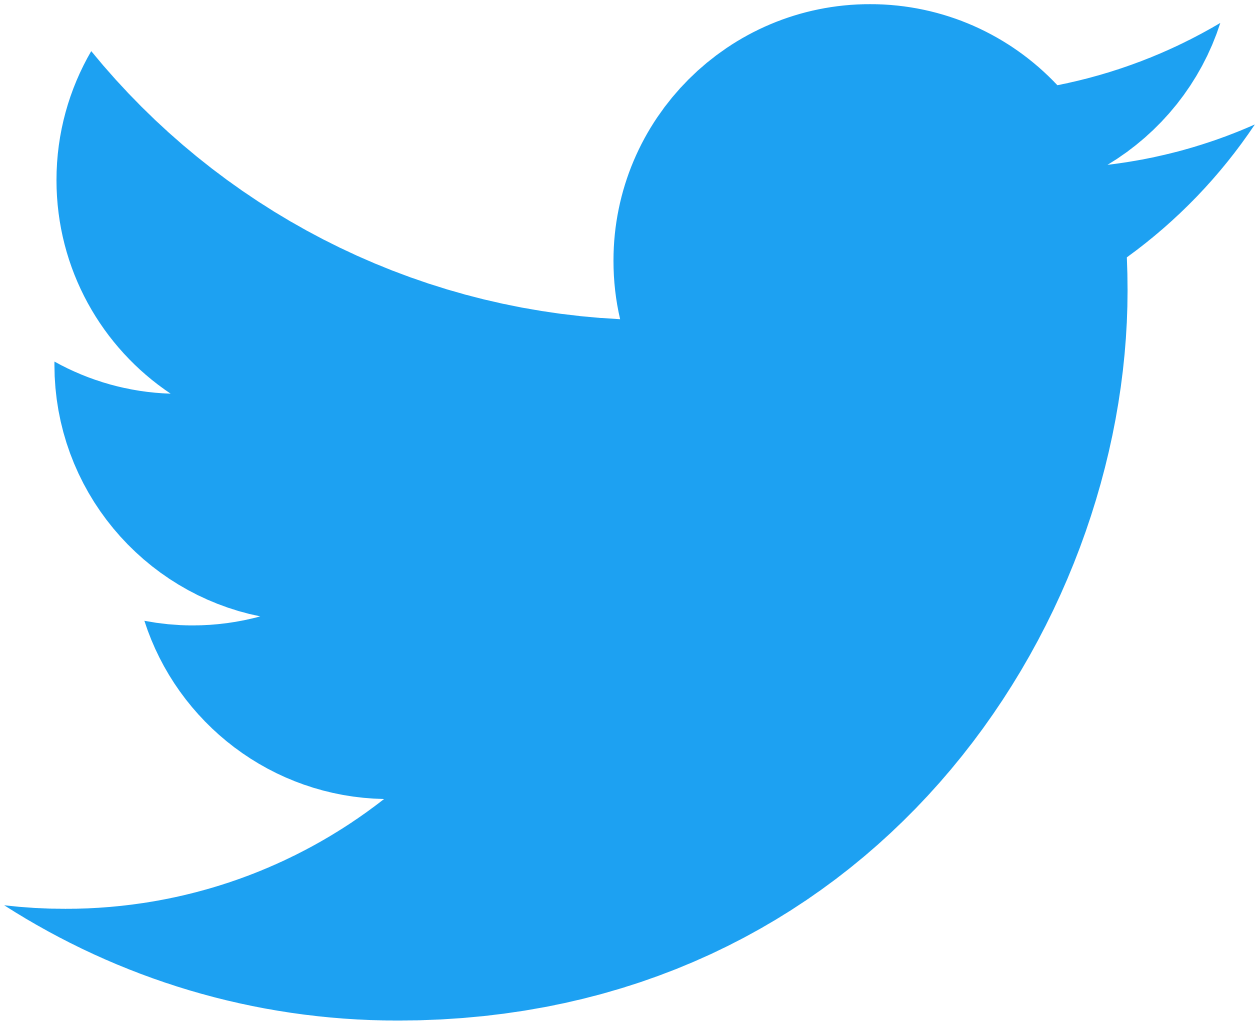

time: 110 ms


In [19]:
#The image for which we will be using as our mask
Image.open('/content/twitter_mask.png')

In [20]:
# Import the twitter logo as an array and verify it's shape
twitter_mask = np.array(Image.open('/content/twitter_mask.png'))
twitter_mask.shape

(1024, 1259, 4)

time: 16.4 ms


In [21]:
def transform_format(val):
  """
  Changes all values of 0 in the image array to 255 to ensure the background is white
  and will be excluded from the mask
  """
  for i in val:
    if i == 0:
      return 255
    else:
      return i

time: 1.96 ms


In [22]:
#We transform and verify the array of our image
transformed_twitter_mask = np.ndarray((twitter_mask.shape[0], twitter_mask.shape[1]), np.int32)

for i in range(len(twitter_mask)):
  transformed_twitter_mask[i] = list(map(transform_format, twitter_mask[i]))

transformed_twitter_mask

array([[255, 255, 255, 255, ..., 255, 255, 255, 255],
       [255, 255, 255, 255, ..., 255, 255, 255, 255],
       [255, 255, 255, 255, ..., 255, 255, 255, 255],
       [255, 255, 255, 255, ..., 255, 255, 255, 255],
       ...,
       [255, 255, 255, 255, ..., 255, 255, 255, 255],
       [255, 255, 255, 255, ..., 255, 255, 255, 255],
       [255, 255, 255, 255, ..., 255, 255, 255, 255],
       [255, 255, 255, 255, ..., 255, 255, 255, 255]], dtype=int32)

time: 2.39 s


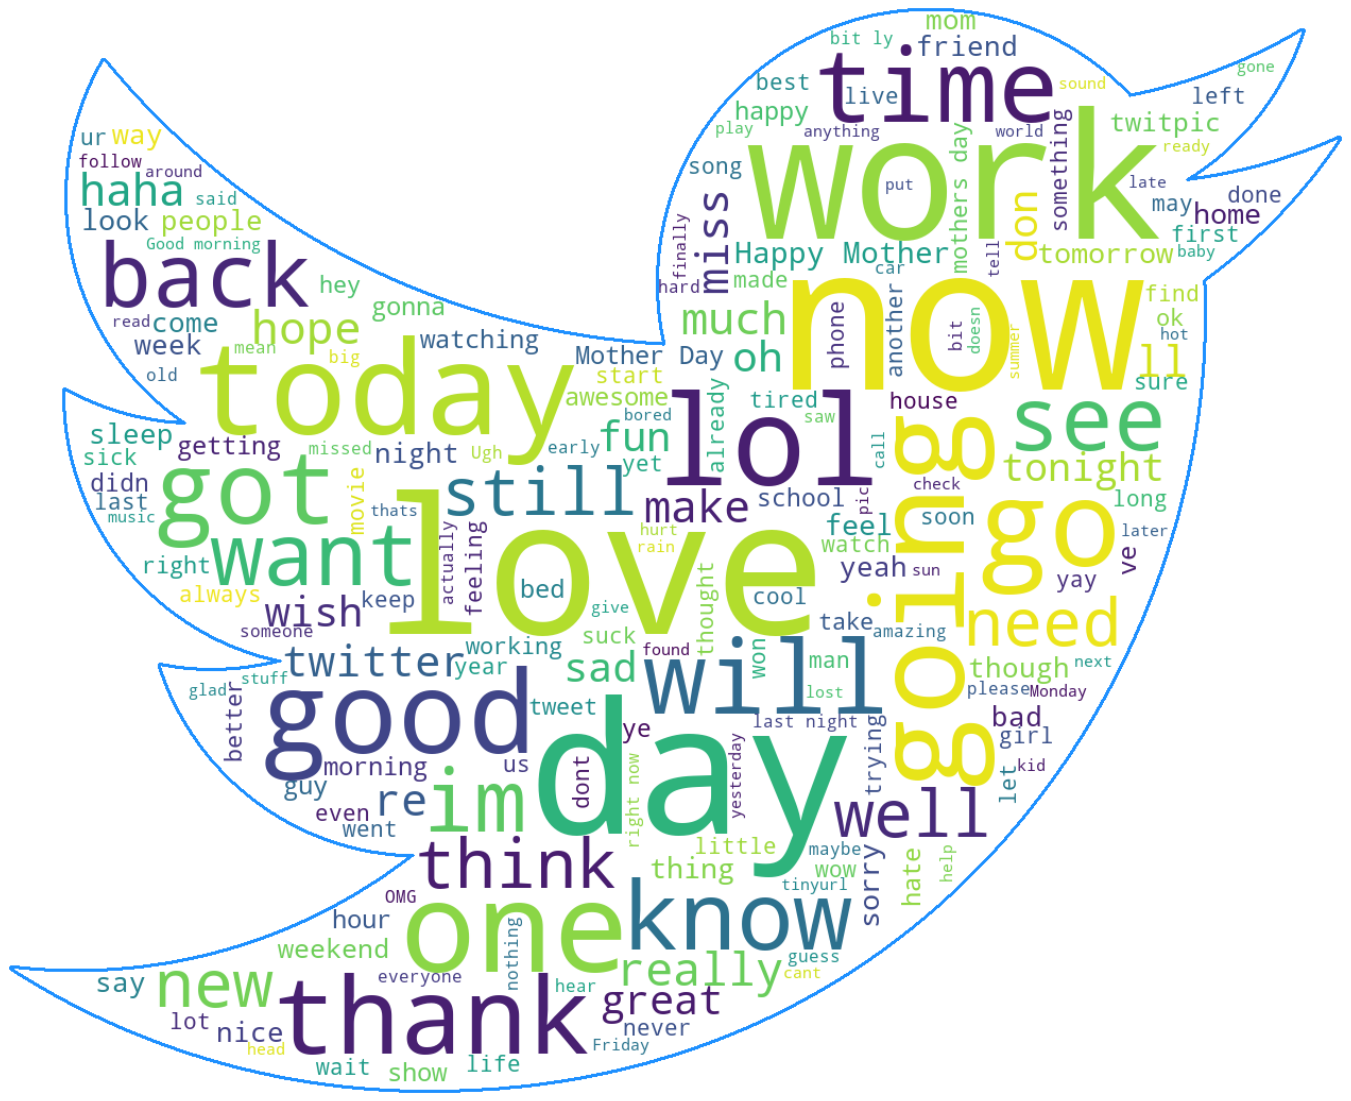

time: 4.39 s


In [23]:
#Generate and show word cloud for all text
wc = WordCloud(background_color='white', mask=transformed_twitter_mask, stopwords=stopwords, contour_width=3, contour_color='dodgerblue', relative_scaling=.75)
wc.generate_from_text(all_text)
plt.figure(figsize = [30,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

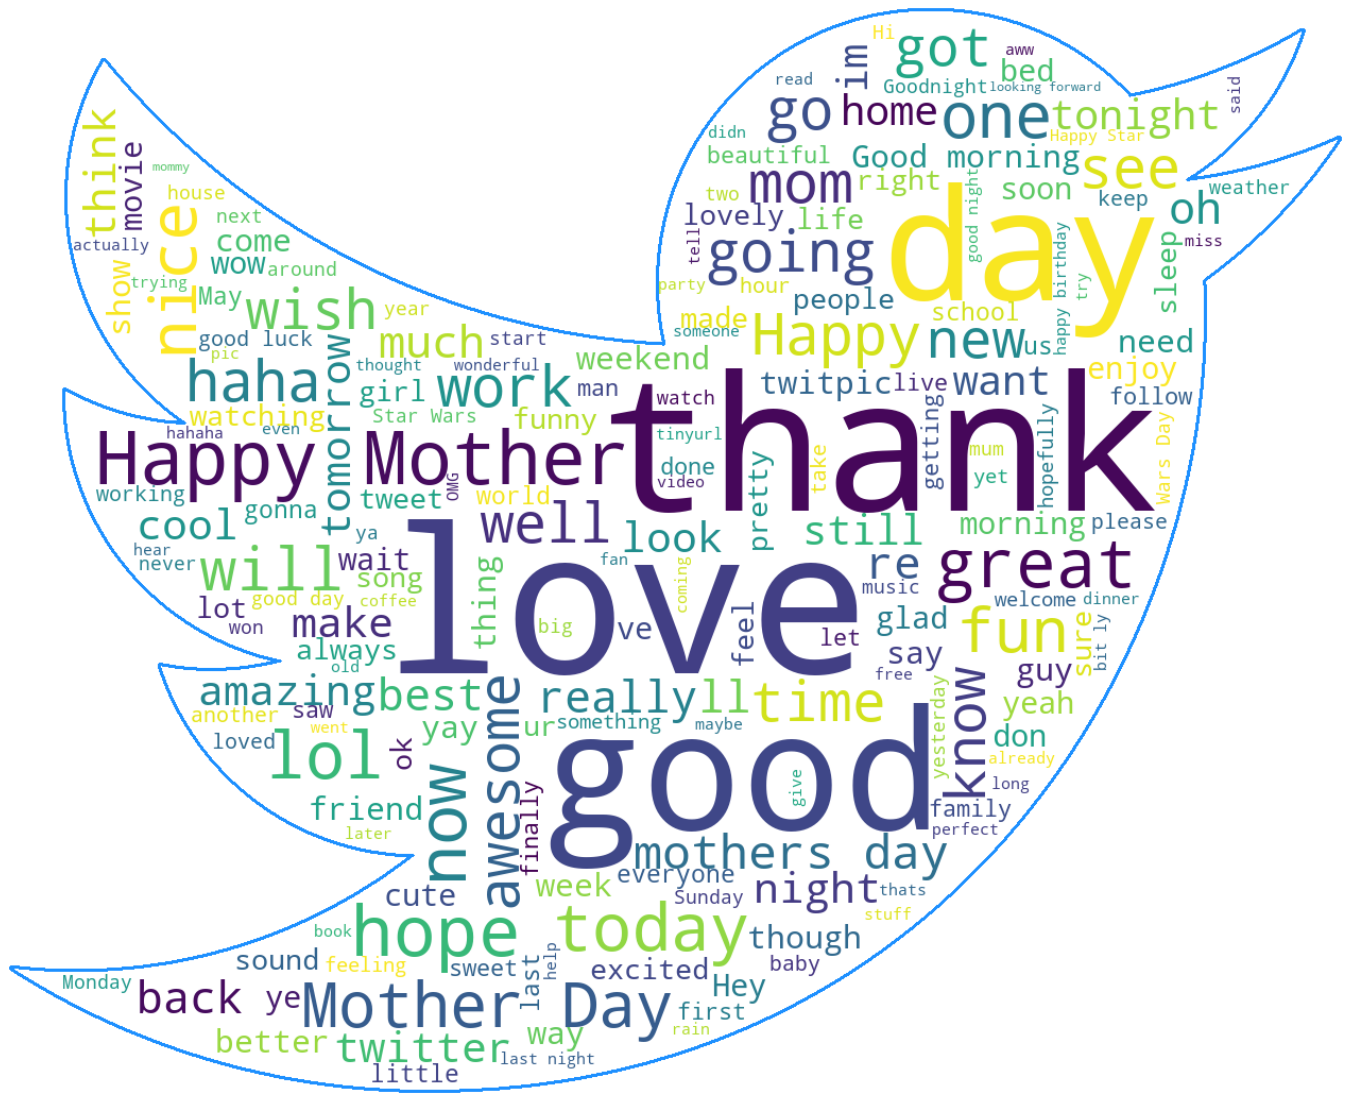

time: 3.55 s


In [24]:
#Generate and show word cloud for all positive text
wc = WordCloud(background_color='white', mask=transformed_twitter_mask, stopwords=stopwords, contour_width=3, contour_color='dodgerblue')
wc.generate_from_text(pos_text)
plt.figure(figsize = [30,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

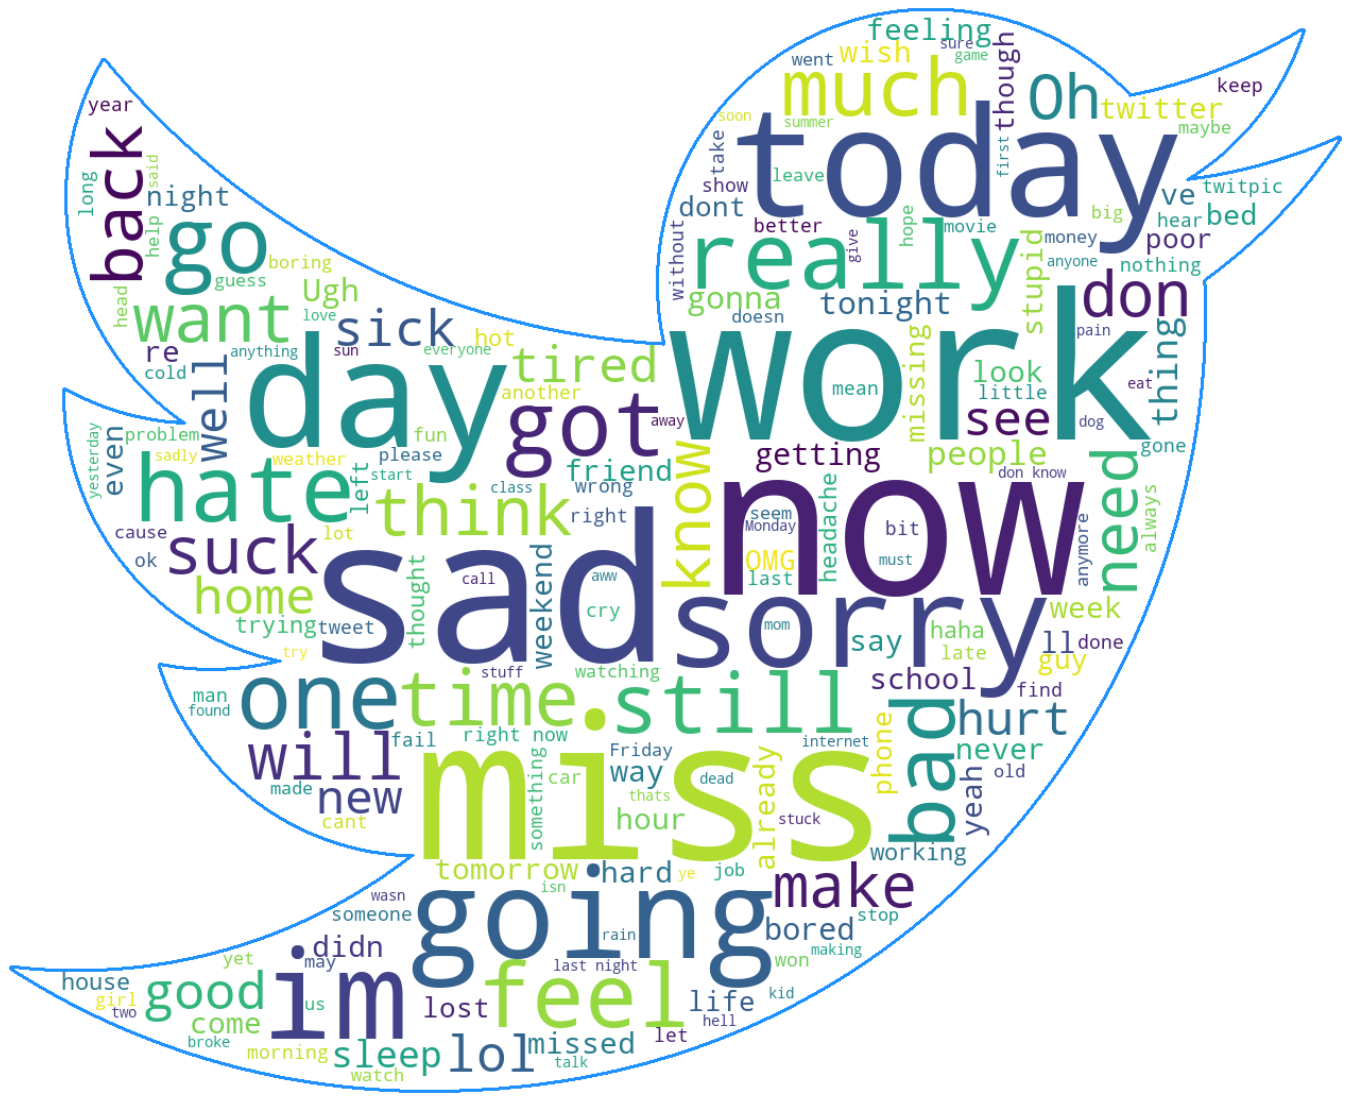

time: 3.45 s


In [25]:
#Generate and show word cloud for all negative text
wc = WordCloud(background_color='white', mask=transformed_twitter_mask, stopwords=stopwords, contour_width=3, contour_color='dodgerblue')
wc.generate(neg_text)
plt.figure(figsize = [30,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

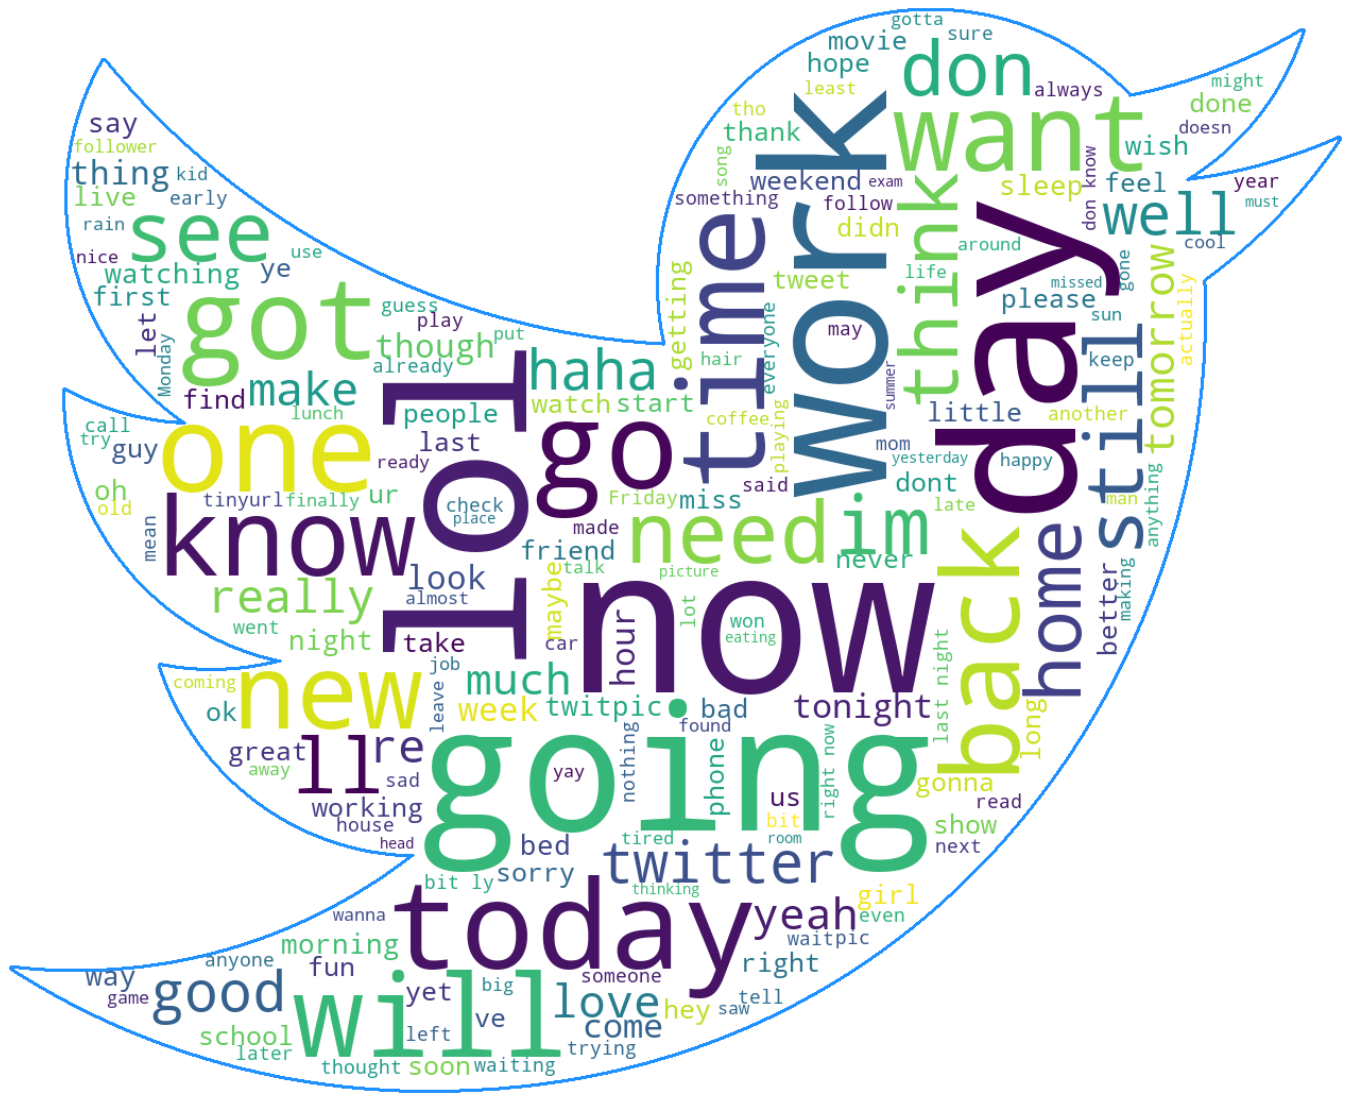

time: 3.64 s


In [26]:
#Generate and show word cloud for all neutral text
wc = WordCloud(background_color='white', mask=transformed_twitter_mask, stopwords=stopwords, contour_width=3, contour_color='dodgerblue')
wc.generate(neutral_text)
plt.figure(figsize = [30,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Language Model

Building the language model we will use the ULMFit method as taught by Jeremy Howard at fastai. Since we are just building the language model the more text the better. We will combine all the tweets from the test and the train dfs. This will help our language model learn the tweet database dialect.  

In [27]:
# Combine both train and test dataframes keeping "sentiment" and "text" columns
text_df = pd.concat([train_df,test_df]).drop(columns=['selected_text','textID'])

# Drop any null values
text_df.dropna(inplace=True)

time: 18.7 ms


In [28]:
# Use train_test_split to create a validation data set for the language model
from sklearn.model_selection import train_test_split

lm_train_df, lm_valid_df = train_test_split(text_df, test_size=.1)

time: 127 ms


In [29]:
# Create databunch class for fastai
data_lm = TextLMDataBunch.from_df(path='/content',train_df=lm_train_df,valid_df=lm_valid_df,text_cols='text', bs=64, max_vocab=100000, min_freq=2)

time: 4.52 s


In [30]:
# Show what the data bunch and see what it looks like after it has been cleaned and tokenized
data_lm.show_batch()

idx,text
0,"cook xxbos still @ the courthouse ! xxmaj happy to have a job ... sad its this one ! xxbos 1 xxup am & time for bed , nite all xxbos xxmaj is pretty xxunk drunk ! xxmaj props to me ! xxmaj two nights in a row ! ! ! xxbos xxmaj haha k we should stop here . xxmaj if not , it`s going to turn into a"
1,"clean house ... finally , so nice xxbos so you are like the rest of us on this miserable bank xxunk xxup lol xxbos xxmaj her new cd is lovely . xxbos xxmaj yep , this is about as ' boonies ' as it gets , if you look at the map xxmaj in transition . xxmaj got ta find a place and a job . - http : /"
2,"xxbos is gutted she is nt going out tonight xxbos - love your new avatar ! xxbos sunny day , sunny outlook xxbos xxmaj today was horrible . xxmaj my xxunk caused me a whole lot of stress and head ache and it ended up ruining a beautiful sunny day . xxbos probably because it`s getting chilly here xxbos i think i left my conference feedback sheet in my bag"
3,"son xxbos xxmaj make your own xxmaj google search page with your name http : / / tinyurl.com / xxunk xxbos the day after xxrep 4 . xxmaj i`m not sick but a little tierd ... a bit to much to drink , but i had fun ! xxbos had a very good day and is now going to get into bed ! xxbos hi guys just doing da xxunk"
4,"thanks , none close to me . xxbos xxmaj with xxmaj my xxmaj boy xxmaj still xxmaj he`s everything to me xxbos online ! xxunk / subscribe xxbos ca nt say i havee , i m at james ` but i did some rs xxunk ! . i m learning my xxunk xxbos xxmaj poor xxmaj nicole just absolutely xxup xxunk her cell phone xxbos back to my interesting emails"


time: 9.72 s


In [31]:
# Create Learn object (same as instantiating a model in sklearn)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

time: 4.54 s


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


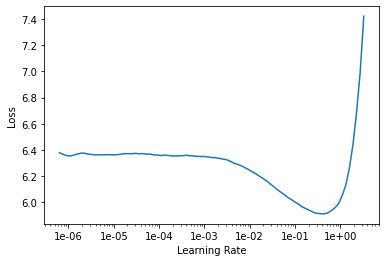

time: 11.9 s


In [32]:
# Find optimal learning rate hyper-parameter
learn.lr_find()
learn.recorder.plot()

In [33]:
# Train the model
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.890437,4.412189,0.220182,00:11


time: 11.4 s


In [34]:
# Train the model
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.403418,4.271030,0.236551,00:14
1,4.273917,4.193729,0.249405,00:14
2,4.102345,4.168462,0.249535,00:14
3,3.971846,4.168871,0.250502,00:14


time: 57.3 s


## Test Language Model

Let's check and see if our language model puts together semi-coherent sentences

In [35]:
text = 'I liked'
n_words = 10
n_sentences=3

print('\n'.join(learn.predict(text, n_words) for _ in range(n_sentences)))

I liked that jungle idea much xxbos coming to saw that rain
I liked him . i was so sad at you`re 4 *
I liked it`s my birthday party ! ! xxbos no open open
time: 607 ms


In [36]:
# Save our language model and our encoder
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

time: 1.03 s


# Classifier

Now we will build and train our classifier

In [37]:
# split the data for a validation data set
clas_train_df,clas_valid_df = train_test_split(train_df,test_size=0.2)
clas_train_df.shape,clas_valid_df.shape

((21984, 7), (5496, 7))

time: 14.6 ms


In [38]:
# Build data bunch for text classifier
data_clf = TextClasDataBunch.from_df(path = '/content', train_df = clas_train_df, valid_df = clas_valid_df, test_df=test_df, vocab=data_lm.vocab, text_cols='text', label_cols= 'sentiment', bs=64)

time: 5.76 s


In [39]:
# Create learn object for classifier
learn = text_classifier_learner(data_clf, arch = AWD_LSTM, drop_mult=0.6)

time: 465 ms


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


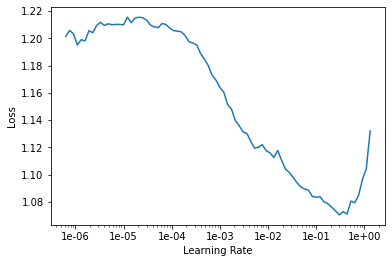

time: 3.14 s


In [40]:
# Load encoder from the language model into our classifier
learn.load_encoder('fine_tuned_enc')

# Find best learning rate for our classifier
learn.lr_find()
learn.recorder.plot()

In [41]:
# Fit last layer
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.846944,0.780315,0.656114,00:07


time: 7.95 s


In [42]:
# Gradual Unfreeze
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.788677,0.686601,0.709243,00:08


time: 8.78 s


In [43]:
# Gradual unfreeze
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.706675,0.624256,0.735080,00:12


time: 12.1 s


In [44]:
# total unfreeze
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.657511,0.622343,0.745269,00:15
1,0.630790,0.597156,0.758370,00:15
2,0.554499,0.585549,0.763282,00:15
3,0.492562,0.602262,0.765102,00:15


time: 1min 2s


# Analyze Classifier Output

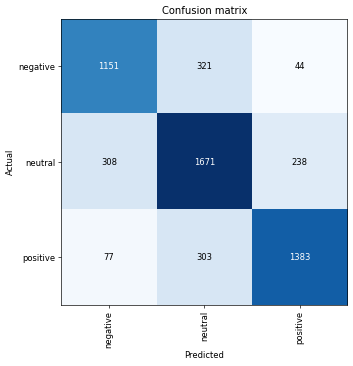

time: 2.44 s


In [45]:
# Save final model and reload
learn.save('final')
learn.load('final')

# view confusion matrix and build interp object
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [46]:
# Text version of confusion matrix (helpful when you have a lot of classes)
interp.most_confused()

[('negative', 'neutral', 321),
 ('neutral', 'negative', 308),
 ('positive', 'neutral', 303),
 ('neutral', 'positive', 238),
 ('positive', 'negative', 77),
 ('negative', 'positive', 44)]

time: 190 ms


In [47]:
# Sum up how many classifications our model got wrong
wrong = []
for idx in interp.most_confused():
  wrong.append(idx[2])
print(f'Total wrong sentiment classifications: {np.array(wrong).sum()}')

Total wrong sentiment classifications: 1291
time: 206 ms


In [48]:
# Make predictions classifying sentiment on a string
learn.predict('this is very good!')

(Category tensor(2), tensor(2), tensor([2.2134e-04, 2.0369e-03, 9.9774e-01]))

time: 192 ms


In [49]:
# Create interpretation object
text_interp = TextClassificationInterpretation.from_learner(learn)

time: 1.22 s


# Selected Text Function


In [50]:
import more_itertools as mit
import numpy as np

def list_output(intrinsic_attention_obj):
  """
  Takes in a fastaiv1 instrinsic attention obj and returns a list 
  of words and a list of the weights associated with those words
  """
  word_str = str(intrinsic_attention_obj[0])
  word_list = word_str.split()
  weight_list = intrinsic_attention_obj[1]
  return word_list, weight_list

def list_filter(word_list, weight_list, vocab):
  """
  Takes in a list of words and a list of weights then returns filtered versions
  based upon the provided vocabulary

  A filtered or sliced version of the vocab can be passed to filter out unwanted
  tokens or words
  """
  filtered_words = []
  filtered_weights = []
  for word, weight in zip(word_list, weight_list):
    if word in vocab:
      filtered_words.append(word)
      filtered_weights.append(float(weight))

  return filtered_words, filtered_weights

def attention_weight_grouper(filtered_weights, threshold):
  """
  Takes in a list of weights and a provided threshold. Returns a list of the indexes
  of the weights that exceed this threshold. 
  """
  weights = []
  ind_list = []
  idx = 0
  for weight in filtered_weights:
    if weight >= threshold:
      weights.append(weight)
      ind_list.append(idx)
    idx += 1
  return  ind_list

def text_output(ind_list, filtered_words, filtered_weights):
  """
  Takes in and ind_list outputed from the attention_weight_grouper function
  along with its filtered words and filtered weights lists. 

  Checks the ind_list for consecutive indices and groups them. Takes the sum of all
  weights associated with the indices in the group and stores the group of indices
  with the largest weight value.

  Returns a string containing the words associated with the indices stored
  """
  groupings = [list(group) for group in mit.consecutive_groups(ind_list)]
  grouping_sum = 0
  grouping_ind = 0
  idx = 0
  for group in groupings:
    if len(group) > 1:
      total = 0
      for id in group:
        total += filtered_weights[id]
        if total > grouping_sum:
          grouping_sum = total
          grouping_ind = idx
      idx += 1
    else:
      ref = group[0]
      total = filtered_weights[ref]
      if total > grouping_sum:
          grouping_sum = total
          grouping_ind = idx
      idx += 1

  #create an empty string and append the chosen words with an extra space at the end
  #to give the text the appropriate format when outputting multiple words
  selected_text = ''
  if len(groupings) > 1:
    for id in groupings[grouping_ind]:
      selected_text += f'{filtered_words[id]} '
  else:
    try:
      if len(groupings[0]) > 1:
        for id in groupings[0]:
          selected_text += f'{filtered_words[id]} '
      else:
        ref = groupings[0][0]
        selected_text += f'{filtered_words[ref]} '
    except:
      np.nan
  #remove the extra space from the end of string string
  selected_text = selected_text[:-1]
  return selected_text

def selected_text_grabber(intrinsic_attention_obj, vocab = data_lm.vocab.itos[9:], threshold = .35):
  """
  Takes in a fastai intrinsic attention obj, a filtered/sliced vocab, and a threshold for significance
  determiniation and applies the list_output, list_filter, attention_weight_grouper, and text_output
  functions to them to transform the object into a string of 'selected_text' 
  """
  word, wt = list_output(intrinsic_attention_obj)
  fil_word, fil_wt = list_filter(word, wt, vocab)
  atn_ind = attention_weight_grouper(fil_wt, threshold)
  return text_output(atn_ind, fil_word, fil_wt)

time: 63.6 ms


# Outputs
This outputs section is for preparing the data to be submitted in the format that Kaggle is looking for.


In [51]:
submission_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


time: 11.7 ms


### Selected Text Grabber Function Test

In [52]:
def df_filter(df, match, text_grabber):
  """
  This function checks the data frame if the sentiment is neutral or not. If it is
  neutral the data will be copied directly from the text column. If the sentiment
  is not neutral it will use the text_grabber function to select the important
  text.
  """
  if df['sentiment'] == match:
    return df['text']
  return text_grabber(text_interp.intrinsic_attention(df['text']))

time: 2.42 ms


In [53]:
# Apply text grabber function on our data frame to prepare it for submission
submission_df['selected_text'] = submission_df.apply(lambda x: df_filter(x, 'neutral', selected_text_grabber), axis = 1)

submission_df.head()

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,really exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like


time: 5min 43s


In [59]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         3534 non-null   object
 1   text           3534 non-null   object
 2   sentiment      3534 non-null   object
 3   selected_text  3534 non-null   object
dtypes: object(4)
memory usage: 110.6+ KB
time: 6.59 ms


### Visuals of Intrinsic Attention

---




*   The darker the red colors means that word's weight is closer to 0 and the word provides negligible value to the sentiment of the sentence
*   The darker the green color means that word's weight is closer to 1 signifying it holds a lot of importance in the regards of its sentiment classification



In [54]:
# Example of the desired selected text we hope to achieve 
train_df.iloc[1]

textID                                                        549e992a42
text                       Sooo SAD I will miss you here in San Diego!!!
selected_text                                                   Sooo SAD
sentiment                                                       negative
jaccard_similarity                                                   0.2
num_words_selectedtext                                                 2
Num_word_text                                                         10
Name: 1, dtype: object

time: 3.8 ms


In [55]:
# Show what intrinsic attention looks like
text_interp.show_intrinsic_attention(train_df['text'][1])

time: 166 ms


In [56]:
# Demonstrate what the selected text of our function looks like
selected_text_grabber(text_interp.intrinsic_attention(train_df['text'][1]))

'sooo sad'

time: 164 ms


In [57]:
# Show what the raw output looks like that we changed into our "selected_text"
text_interp.intrinsic_attention(train_df['text'][1])

(Text [   2    5  456    6  143   10   81  120   18  116   23    5 1446    5 2517   11   11   11],
 tensor([0.0855, 0.1071, 0.8021, 0.1865, 1.0000, 0.1814, 0.2878, 0.6919, 0.2021,
         0.1638, 0.0795, 0.0493, 0.4150, 0.0423, 0.1272, 0.1829, 0.1863, 0.2491],
        device='cuda:0'))

time: 185 ms


In [58]:
sample_df = test_df.head()
sample_df['selected_text'] = sample_df.apply(lambda x: df_filter(x, 'neutral', selected_text_grabber), axis = 1)
sample_df

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,really exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like


time: 685 ms
